In [1]:
# import needed libraries
import numpy as np
import argparse
import time
from random import shuffle
import random
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/content/myDrive/')

Mounted at /content/myDrive/


In [3]:
# change folder to ZSL one with data/ and utils/
cd myDrive/MyDrive/ZSL

/content/myDrive/MyDrive/ZSL


# Zero shot learning - final project
## DL for Spiking Neural Networks and Advanced Data Mining

In [4]:
from scipy import io
att_splits=io.loadmat('./data/CUB/att_splits.mat')
# get string classes names
classes_names = [a[0] for a in np.squeeze(att_splits['allclasses_names'])]
# create helper dictionary from class id to class name
id_to_name = {int(name.split('.')[0]):name.split('.')[1] for name in classes_names}

### Reading data

In [5]:
from utils import data_loader
import importlib
# load /utils/data_loader
importlib.reload(data_loader)
# load the data
trainDataX, trainDataLabels, trainDataAttrs, testDataX, testDataLabels, testDataAttrs = data_loader.DataLoader("./data/CUB", binary=False).load()
trainDataX = (trainDataX - np.mean(trainDataX)) / np.std(trainDataX) # normalize image embeddings
testDataX = (testDataX - np.mean(testDataX)) / np.std(testDataX) # normalize image embeddings

# get the number of testing examples
test_size = len(testDataLabels)

In [6]:
# check total number of classes (test & train)
num_classes = len(np.unique(np.concatenate((trainDataLabels, testDataLabels))))
num_classes

200

In [7]:
# prepare the input tensor for the model
in_shape = trainDataX.shape[1]
inputs = Input(shape=(in_shape,))

### Define useful for evaluation dictionaries

In [8]:
# create class_id:attribute dictionary
class_attr_dict = {}
for A, B in zip(trainDataLabels, trainDataAttrs):
    # training classes
    class_attr_dict[A] = B
for A, B in zip(testDataLabels, testDataAttrs):
    # testing classes
    class_attr_dict[A] = B

keys = sorted(class_attr_dict)
class_attr_dict = {i: class_attr_dict[i] for i in keys}
class_attr_dict.keys()

# create inverse, that is attribute:class_id dictionary
atrr_to_class = {v.tobytes(): k for k, v in class_attr_dict.items()}
all_class_atrs = class_attr_dict.values()


In [9]:
# create class_id:attribute dictionary for test classes
test_attributes = {}
for A, B in zip(testDataLabels, testDataAttrs):
    test_attributes[A] = B
test_attributes = test_attributes.values()

In [10]:
# all classes names in test dataset
classes = [id_to_name[label] for label in np.unique(testDataLabels)]
# helper: class name (str) to id in confusion matrix dictionary
class_to_conf_matrix = {cl:i for i,cl in enumerate(classes)}

In [11]:
def difference(class_attribute, prediction):
    ''' calulate difference between predicted and actual attribute values '''
    #assert(len(class_attribute) == len(prediction))
    dif = 0

    # iterate trough given actual class atribute representation
    for i, att in enumerate(class_attribute):
        # compare it with the prediction
        dif += abs(prediction[i] - att)

    # return sum of differences
    return dif

def evaluate(pred, printing=False):
  ''' get accuracy of the given model given its prediction of test dataset '''
  # initialize counter of correctly predicted examples
  correct = 0
  # initialize confusion matrix with 0s
  confusion_matrix = [[0]*len(classes) for i in range(len(classes))]

    # iterate through each test example
  for id in range(test_size-1):
    # get distance score
    differences = [difference(att, pred[id]) for att in test_attributes]

    # take the id of the min distance
    id_predicted = np.argmin(differences)
    # retrive the class id of the min distance
    class_prediction = atrr_to_class[list(test_attributes)[id_predicted].tobytes()]

    # optional printing
    if printing:
      print(f"predicted class: {class_prediction} real class : {testDataLabels[id]}")
      print(f"predicted class: {id_to_name[class_prediction]} real class : {id_to_name[testDataLabels[id]]}")
      print(f"CORRECT:::??? ->>> {class_prediction == testDataLabels[id]}")

    # if correct, add to correct variable
    if class_prediction == testDataLabels[id]:
      correct += 1

    # update confusion matrix
    confusion_matrix[class_to_conf_matrix[id_to_name[testDataLabels[id]]]][class_to_conf_matrix[id_to_name[class_prediction]]] += 1

  # return accuracy
  return correct/test_size, confusion_matrix

In [20]:
# create the model
x = Dense(700)(inputs)
# final layer 312 neurons as 312 attributes in CUB dataset
x = Dense(312, activation='linear')(x)

model1 = Model(inputs, x)

# low lr, as otherwise overshooting
model1.compile(optimizer=Adam(learning_rate=0.0005), loss='mae', metrics=['mae'])

hist1 = model1.fit(trainDataX, trainDataAttrs, batch_size=64, shuffle=True, epochs=10, callbacks=[EarlyStopping(monitor='loss',min_delta=0.0001, patience=2)])

Epoch 1/10
138/138 [==============================] - 2s 4ms/step - loss: 0.4292 - mae: 0.4292
Epoch 2/10
138/138 [==============================] - 1s 4ms/step - loss: 0.2111 - mae: 0.2111
Epoch 3/10
138/138 [==============================] - 1s 4ms/step - loss: 0.1429 - mae: 0.1429
Epoch 4/10
138/138 [==============================] - 1s 5ms/step - loss: 0.1064 - mae: 0.1064
Epoch 5/10
138/138 [==============================] - 1s 4ms/step - loss: 0.0837 - mae: 0.0837
Epoch 6/10
138/138 [==============================] - 1s 4ms/step - loss: 0.0689 - mae: 0.0689
Epoch 7/10
138/138 [==============================] - 0s 3ms/step - loss: 0.0582 - mae: 0.0582
Epoch 8/10
138/138 [==============================] - 0s 3ms/step - loss: 0.0495 - mae: 0.0495
Epoch 9/10
138/138 [==============================] - 0s 3ms/step - loss: 0.0434 - mae: 0.0434
Epoch 10/10
138/138 [==============================] - 0s 3ms/step - loss: 0.0380 - mae: 0.0380


In [21]:
# predicting testing examples & evaluate
acc, conf_matrix = evaluate(model1.predict(testDataX))

93/93 [==============================] - 0s 2ms/step


In [22]:
acc # print accuracy score

0.3468149646107179

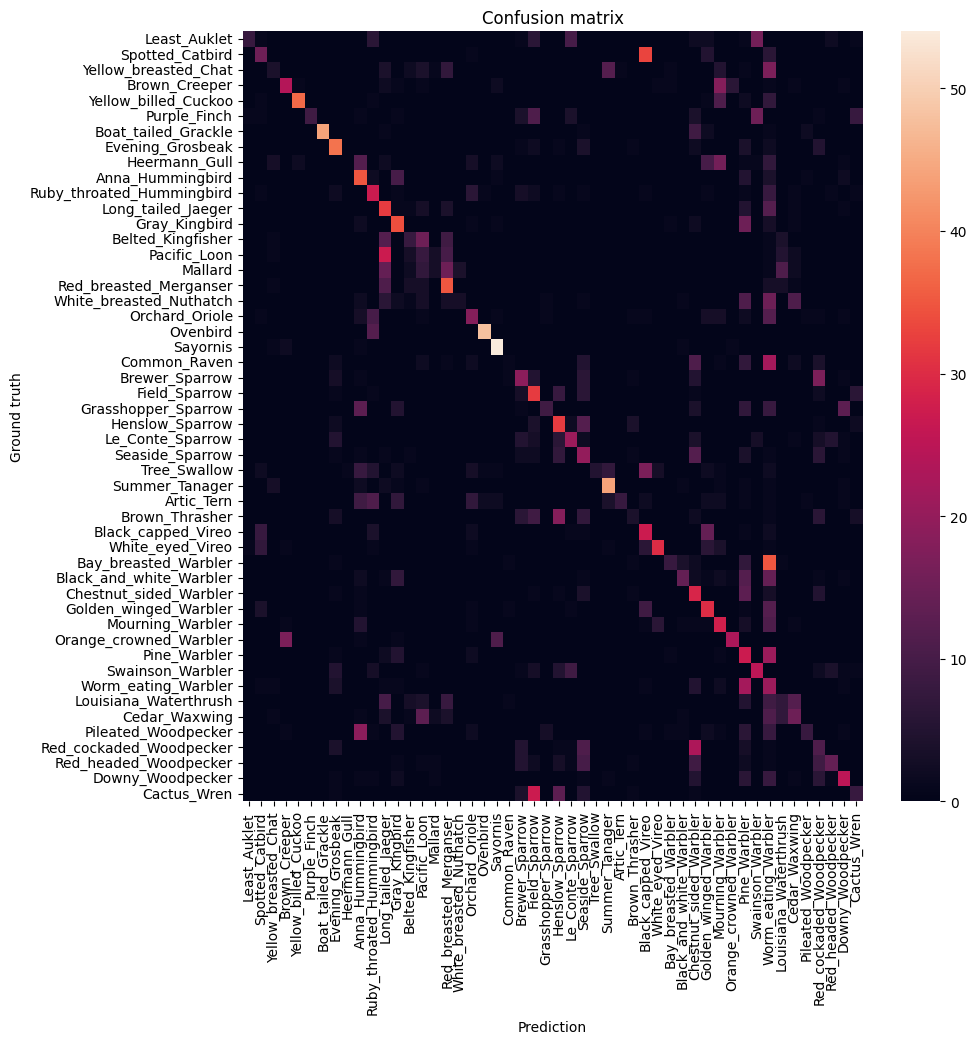

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualise confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix, ax = ax, xticklabels = classes, yticklabels = classes, fmt='d')
ax.set_title('Confusion matrix')
ax.set_ylabel('Ground truth')
ax.set_xlabel('Prediction')
plt.show()